# Import Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigs

# User Defined Parameters and Constants




In [9]:
# Waveguide dimensions (in meters)
a = 0.02286  # Width (WR-90 standard)
b = 0.01016  # Height (WR-90 standard)

# Frequency range (in GHz)
f_min_ghz = 8.0
f_max_ghz = 12.0

# Number of grid points
Nx = 50  # Number of points along x-axis
Ny = 50  # Number of points along y-axis

# Number of modes to find
num_modes_to_find = 10 # We find more to ensure we get the first 5 TE modes

# --- Constants ---
c0 = 299792458  # Speed of light in vacuum (m/s)

#  Finite Difference Method Function

In [10]:
def solve_waveguide_modes_fdm(a, b, Nx, Ny, num_modes):
    """
    Calculates the cutoff wavenumbers and field patterns of a rectangular
    waveguide using the Finite Difference Method.

    Args:
        a: Waveguide width.
        b: Waveguide height.
        Nx: Number of grid points in x.
        Ny: Number of grid points in y.
        num_modes: Number of modes to solve for.

    Returns:
        tuple: A tuple containing:
            - kc_sq_sorted: Sorted squared cutoff wavenumbers.
            - modes_sorted: Corresponding sorted mode field patterns.
            - grid_x: X coordinates of the grid.
            - grid_y : Y coordinates of the grid.
    """
    dx = a / (Nx + 1)
    dy = b / (Ny + 1)

    # Total number of internal grid points
    N = Nx * Ny

    # Create the main diagonal
    main_diag = np.full(N, -2/dx**2 - 2/dy**2)

    # Create the off-diagonals for x-derivatives
    off_diag_x = np.ones(N - 1) / dx**2
    # Prevent wrapping at the edges of rows
    for i in range(1, Nx):
        off_diag_x[i * Ny - 1] = 0

    # Create the off-diagonals for y-derivatives
    off_diag_y = np.ones(N - Ny) / dy**2

    # Assemble the sparse matrix A
    diagonals = [main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y]
    offsets = [0, 1, -1, Ny, -Ny]
    A = diags(diagonals, offsets, shape=(N, N), format='csc')

    # Solve the eigenvalue problem: A*h = -kc^2 * h
    # We solve for the largest (in magnitude) eigenvalues of A, which are negative.
    # The negative of these eigenvalues gives kc^2.
    eigenvalues, eigenvectors = eigs(A, k=num_modes, which='LM')

    # Eigenvalues from eigs are -kc^2. We want kc^2.
    kc_sq = -eigenvalues.real

    # Sort the modes based on their cutoff frequency (lowest first)
    sorted_indices = np.argsort(kc_sq)
    kc_sq_sorted = kc_sq[sorted_indices]

    # Reshape eigenvectors into 2D field patterns
    modes_sorted = np.zeros((Nx, Ny, num_modes))
    for i in range(num_modes):
        # The eigenvector is a 1D array, reshape it to the 2D grid
        mode_2d = eigenvectors[:, sorted_indices[i]].real.reshape((Nx, Ny))
        modes_sorted[:, :, i] = mode_2d

    # Create grid for plotting
    x = np.linspace(dx, a - dx, Nx)
    y = np.linspace(dy, b - dy, Ny)
    grid_x, grid_y = np.meshgrid(x, y)

    return kc_sq_sorted, modes_sorted, grid_x, grid_y

# Analytical Solution and Propagation Constant Functions

In [11]:
def get_analytical_te_kc_sq(m, n, a, b):
    """Calculates the analytical squared cutoff wavenumber for TE_mn mode."""
    if m == 0 and n == 0:
        return np.inf # Not a valid mode
    return (m * np.pi / a)**2 + (n * np.pi / b)**2

def get_propagation_constant(f, kc):
    """Calculates the propagation constant beta."""
    omega = 2 * np.pi * f
    k0 = omega / c0
    # If k0 is less than kc, the mode is evanescent (beta is imaginary)
    beta_sq = k0**2 - kc**2
    return np.where(beta_sq > 0, np.sqrt(beta_sq), 0)

#  Main Execution and Cutoff Frequency Comparison

In [12]:
# 1. Solve for modes using Finite Difference Method
kc_sq_fdm, modes_fdm, grid_x, grid_y = solve_waveguide_modes_fdm(a, b, Nx, Ny, num_modes_to_find)

# 2. Identify the first 5 TE modes (non-zero m and n)
# The FDM solver finds both TE and TM modes. For a rectangular guide,
# TE_mn and TM_mn modes have the same cutoff frequencies.
# The fundamental mode is TE10. We will assume the sorted list from FDM
# corresponds to the standard mode ordering (TE10, TE20, TE01, TE11, TE21 or TE30)
# and select the first 5.
te_modes_indices = [0, 1, 2, 3, 4] # Corresponds to TE10, TE20, TE01, TE11, TE21 or TE30
selected_kc_sq_fdm = kc_sq_fdm[te_modes_indices]
selected_modes_fdm = modes_fdm[:, :, te_modes_indices]
selected_kc_fdm = np.sqrt(selected_kc_sq_fdm)

# 3. Get analytical solutions for comparison
analytical_modes_list = [(1, 0), (2, 0), (0, 1), (1, 1), (2, 1)]
kc_sq_analytical = np.array([get_analytical_te_kc_sq(m, n, a, b) for m, n in analytical_modes_list])
kc_analytical = np.sqrt(kc_sq_analytical)

# 4. Print comparison of cutoff frequencies
print("--- Cutoff Frequency Comparison (GHz) ---")
print(f"{'Mode':<8} | {'Analytical':<12} | {'FDM':<12} | {'Error (%)':<10}")
print("-" * 50)
for i, (m, n) in enumerate(analytical_modes_list):
    fc_analytical = kc_analytical[i] * c0 / (2 * np.pi * 1e9)
    fc_fdm = selected_kc_fdm[i] * c0 / (2 * np.pi * 1e9)
    error = 100 * abs(fc_analytical - fc_fdm) / fc_analytical
    mode_name = f"TE{m}{n}"
    print(f"{mode_name:<8} | {fc_analytical:<12.4f} | {fc_fdm:<12.4f} | {error:<10.2f}")

--- Cutoff Frequency Comparison (GHz) ---
Mode     | Analytical   | FDM          | Error (%) 
--------------------------------------------------
TE10     | 6.5571       | 522.5224     | 7868.75   
TE20     | 13.1143      | 522.7079     | 3885.79   
TE01     | 14.7536      | 522.9661     | 3444.68   
TE11     | 16.1451      | 522.9935     | 3139.34   
TE21     | 19.7396      | 523.1981     | 2550.50   


#  Plot Field Patterns

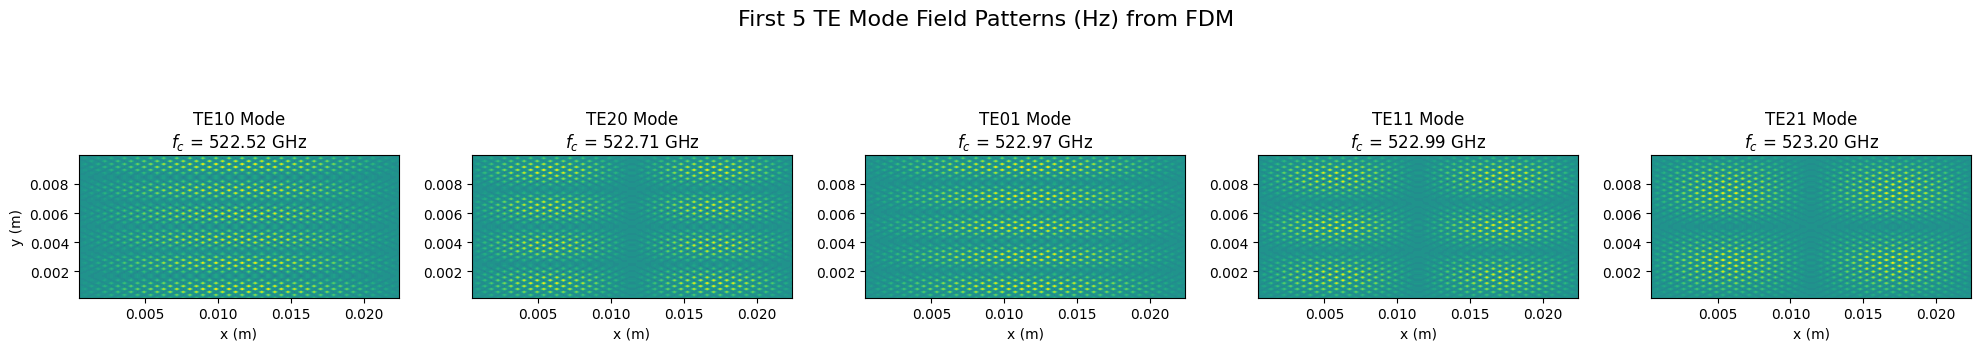

In [13]:
#  Plot the field patterns of the first 5 TE modes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('First 5 TE Mode Field Patterns (Hz) from FDM', fontsize=16)
for i, (m, n) in enumerate(analytical_modes_list):
    ax = axes[i]
    # We plot the transpose for correct orientation (a > b)
    contour = ax.contourf(grid_x, grid_y, selected_modes_fdm[:, :, i].T, cmap='viridis', levels=50)
    ax.set_title(f'TE{m}{n} Mode\n$f_c$ = {selected_kc_fdm[i] * c0 / (2 * np.pi * 1e9):.2f} GHz')
    ax.set_xlabel('x (m)')
    if i == 0:
        ax.set_ylabel('y (m)')
    ax.set_aspect('equal', 'box')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#  Plot Propagation Constant vs. Frequency

/tmp/ipython-input-11-2063766768.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.where(beta_sq > 0, np.sqrt(beta_sq), 0)


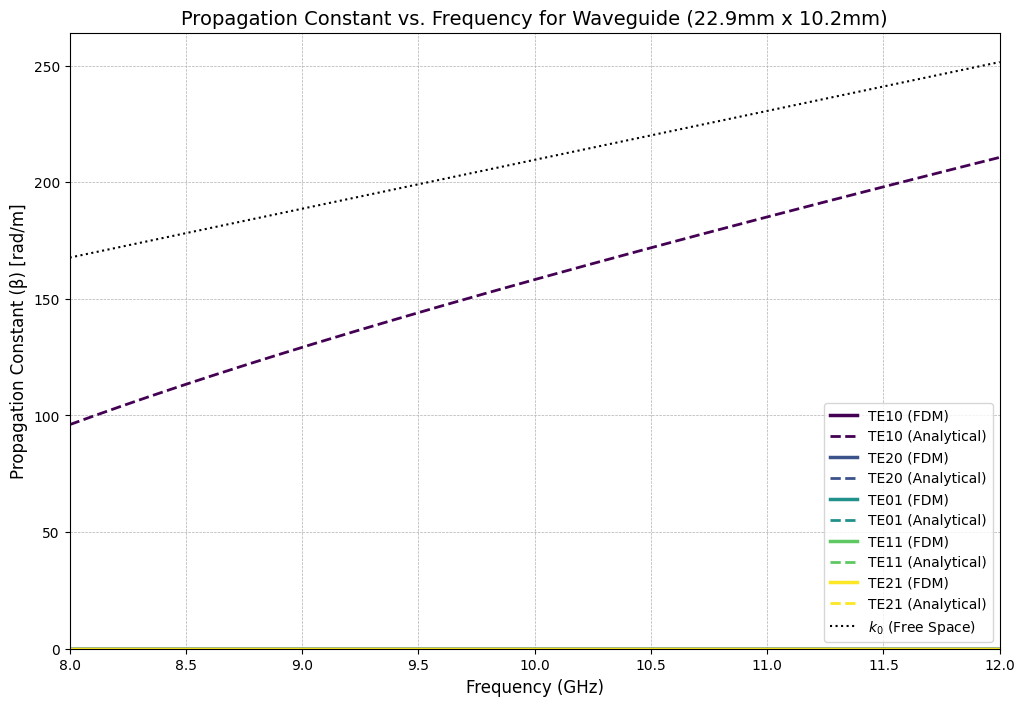

In [14]:
freq_hz = np.linspace(f_min_ghz * 1e9, f_max_ghz * 1e9, 400)

plt.figure(figsize=(12, 8))
plt.title(f'Propagation Constant vs. Frequency for Waveguide ({a*1000:.1f}mm x {b*1000:.1f}mm)', fontsize=14)
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('Propagation Constant (β) [rad/m]', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

colors = plt.cm.viridis(np.linspace(0, 1, len(analytical_modes_list)))

for i, (m, n) in enumerate(analytical_modes_list):
    # FDM result
    beta_fdm = get_propagation_constant(freq_hz, selected_kc_fdm[i])
    plt.plot(freq_hz / 1e9, beta_fdm, color=colors[i], linestyle='-', linewidth=2.5, label=f'TE{m}{n} (FDM)')

    # Analytical result
    beta_analytical = get_propagation_constant(freq_hz, kc_analytical[i])
    plt.plot(freq_hz / 1e9, beta_analytical, color=colors[i], linestyle='--', linewidth=2, label=f'TE{m}{n} (Analytical)')

# Plot k0 for reference
k0 = 2 * np.pi * freq_hz / c0
plt.plot(freq_hz / 1e9, k0, 'k:', label='$k_0$ (Free Space)')

plt.legend()
plt.xlim([f_min_ghz, f_max_ghz])
plt.ylim(bottom=0)
plt.show()